In [1]:
## based on https://dynetworkx.readthedocs.io/en/latest/tutorial.html
import dynetworkx as dnx
import networkx as nx

import numpy as np
from numpy.random import PCG64
# use matplotlib to visualize graph?
# see https://www.geeksforgeeks.org/python-visualize-graphs-generated-in-networkx-using-matplotlib/
%matplotlib notebook        
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # plot in 3D

######## IMPORT MY OWN MODULES ########
from trajectory import *          # import the simulator loop 

In [2]:
### environment constants
x_lim    = [0.2, 0.9]
y_lim    = [0., 10.]
z_lim    = [0., 2.7]

# for the fruit distribution, want to keep it the same for these tests
x_seed = PCG64(37428395352013185889194479428694397783)
y_seed = PCG64(13250124924871709375127216220749555998)
z_seed = PCG64(165440185943501291848242755689690423219)

# density of "fruit" in the orchard
density = 10


### robot constants
n_arm  = 3   # K in melon paper
n_cell = 1   # keeping it simple for now

# vehicle speed
v = 0.01   # in m/s 

# 'fruit handling time window,' a constant worst case value (for now)
Tw_con = 5.     # in sec

# cell width/height (perpendicular to movement) and length (parallel to movement)
cell_h = z_lim[1] - z_lim[0]  # w in paper
cell_l = 0.3                  # length of cell

# arm starting locations
arm_location = np.zeros([n_arm, 3])
offset       = 0.2

arm_location[:,0] = 0. # x-coordinate start
arm_location[:,2] = 0. # z-coordinate start

for k in range(n_arm):
    # set the arms at their respective starting y-coord locations based on offset
    arm_location[k,1] = k*offset # y-coordinate start -> assumes #0 is at the back, rest of code doesn't
    
# print(arm_location)

In [3]:
## Interval graph node setup
class fruitNode:
    def __init__(self, i, j, k, t): 
        # ith fruit
        self.i  = i
        # jth fruit picked by this arm
        self.j  = j
        # arm for which edges are being calculated
        self.k  = k
        # jth fruit i that the arm k has picked up, denoted t^{k}_{i(j)}, previous fruit 
        # would be t^{k}_{i(j-1)}
        # time at which kth arm reaches the jth fruit it has picked up
        self.t  = t 

In [4]:
## Functions
def calcTm(traj_calc, start_y, start_z, fruit_y, fruit_z):
    '''
       Calculate Tm (moving time -> move in y,z to next fruit) for node i for arm k.
    '''
    # arm settings
    v_max = 0.8
    a_max = 3.1
    d_max = a_max
    
    # calculate move in y-axis
    traj_calc.adjInit(start_y, 0.) # start moving from zero speed
    traj_calc.noJerkProfile(traj_calc.q0, fruit_y, traj_calc.v0, v_max, a_max, d_max)
    
    t_y = traj_calc.Ta + traj_calc.Tv + traj_calc.Td 
    
    # calculate conveyor drop off
    traj_calc.adjInit(start_z, 0.) 
    traj_calc.noJerkProfile(traj_calc.q0, fruit_z, traj_calc.v0, v_max, a_max, d_max)
    
    t_z = traj_calc.Ta + traj_calc.Tv + traj_calc.Td 
    
    # calculate which will dominate
    Tm = max(t_y, t_z)
    
    return(Tm)


def calcTd(traj_calc, fruit_x, fruit_z):
    '''
       Calculate Td (handling time -> extension + retraction + conveyor drop off + pick time) 
       for node i.
    '''
    # constants
    t_grab = 0.1 
    # arm settings
    v_max = 0.8
    a_max = 3.1
    d_max = a_max
    
    # calculate extension (retraction)
    traj_calc.adjInit(0., 0.)      # starts at zero for x each time (extend to fruit)
    traj_calc.noJerkProfile(traj_calc.q0, fruit_x, traj_calc.v0, v_max, a_max, d_max)
    
    t_x = traj_calc.Ta + traj_calc.Tv + traj_calc.Td 
    
    # calculate conveyor drop off
    traj_calc.adjInit(fruit_z, 0.) # starts at fruit's location (move to conveyor from fruit)
    traj_calc.noJerkProfile(traj_calc.q0, 0., traj_calc.v0, v_max, a_max, d_max)
    
    t_z = traj_calc.Ta + traj_calc.Tv + traj_calc.Td 
    
    # add them all together
    Td = t_grab + 2*t_x + t_z
    
    return(Td)


def intervalGraph(k, ystart, ystop, color='b'):
    '''Interval graph of the edges with given k arm and color.''' 
    # plot the interval
    plt.hlines(k, ystart, ystop, color, lw=4)
    # plots the whiskers/ends
    plt.vlines(ystart, k+0.03, k-0.03, color, lw=2)
    plt.vlines(ystop, k+0.03, k-0.03, color, lw=2)


In [5]:
## Create fruit data set
len_x = x_lim[1] - x_lim[0]            
len_y = y_lim[1] - y_lim[0]  
len_z = z_lim[1] - z_lim[0]

numFruit = int(density * (len_y*len_x*len_z))  

x = np.random.default_rng(x_seed).uniform(x_lim[0], x_lim[1], numFruit)
y = np.random.default_rng(y_seed).uniform(y_lim[0], y_lim[1], numFruit)
z = np.random.default_rng(z_seed).uniform(z_lim[0], z_lim[1], numFruit)

# need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
fruit = np.stack([x, y, z])

axis_to_sort = np.argsort(y) # sort based on y-axis
sortedFruit = fruit[:,axis_to_sort]

# create an array (or list if it'll need to be dynamic later) for node objects
node_array  = np.ndarray(numFruit+n_arm, dtype=object)  # numFruit+arm_node for the initial dummy nodes for each arm

In [6]:
## Initialize the interval graph
IG = dnx.IntervalGraph()

# arm settings, also in calcTd function
v_max = 0.8
a_max = 3.1
d_max = a_max

## initialize the ability to calculate trajectory
traj_calc = Trajectory(v_max, a_max, d_max)

In [7]:
## (a) initialize dummy 0 nodes for each arm k
for k in range(n_arm): 
    node_array[k] = fruitNode(0, 0, k, 0)
    IG.add_node(node_array[k])
    
# IG.nodes(data=True) # show the attributes for each node (maybe not necessary)
print('did the dummy node for k=1 get created?', IG.has_node(node_array[1]))
print('k value for dummy node for k=1 (should be = 1):', node_array[1].k)

for i in range(numFruit):
    node_array[i+3] = fruitNode(i, 0, n_arm, 0) # k = n_arm which is > n-1 (index) to identify unpicked fruit
    IG.add_node(node_array[i+3])
    
print('number of fruit:', numFruit)    
print('number of nodes after adding all fruit:', len(IG.nodes()))

did the dummy node for k=1 get created? True
k value for dummy node for k=1 (should be = 1): 1
number of fruit: 189
number of nodes after adding all fruit: 192


In [9]:
# (b) process nodes in order of increasing y-coord
# Td = np.zeros(n_arm)
t  = np.zeros([n_arm, numFruit+1]) # t of arm k when picking fruit i
U  = np.zeros(2) # saves the interval edges

# update this for when there are more than three arms
last_i = np.array([node_array[0], node_array[1], node_array[2]]) # saves the fruit id of the fruit last picked by the arm k 
curr_j = np.array([node_array[0].j, node_array[1].j, node_array[2].j]) # saves the number of fruit being picked by 
# the kth arm

for i in range(n_arm, numFruit+n_arm): # takes into account the dummy nodes
#     print('i:', i, 'and i-3 (dummy nodes added):', i-3)
    # determine if the node i lies within the range of fewer than K preceding intervals of  
    # nodes included in the solution
    # calculate handling time for the fruit
    Td     = calcTd(traj_calc, sortedFruit[0, i-n_arm], sortedFruit[2, i-n_arm])
#     print('Td', Td)
    U[0] = sortedFruit[1, i-n_arm]   # the y-coordinate is U^{k}_{i}[0], the beginning interval edges
     
    for k in range(n_arm):
#         print('number of fruit arm', k, 'has picked:', curr_j[k])
        
        # for arm k, the previous t^{k}_{ij} is 
        prev_t = last_i[k].t
#         print('the value for t^{k}_{i(j-1)} is', prev_t, 's')
        
        # calculate the time that the kth arm reaches fruit i, the jth fruit it has picked up, at coordinate 
        # yi => they index k = 1, we index k = 0... sigh
        t[k,i-n_arm] = np.amax([prev_t+Td, (sortedFruit[1,i-n_arm]+k*cell_l)/v]) # or more is when it would be able to reach this next fruit
#         print('the value for the new t^{k}_{i(j)} is', t[k,i-n_arm], 's')
#         t[k,i,pot_j] = np.amax([t[k,i,pot_j-1]+Td, (sortedFruit[1,i]+(k)*cell_l)/v]) # or more is when it would be able to reach this next fruit

        # calculate U^{k}_{i}[1], the interval edge end
        ## NOTE: velocity needs to be high enough that v*(Td + t[k,i-n_arm]) - (k+1)*cell_l > 0?
        print('arm number:', k)
        U[1]   = v*(Td + t[k,i-n_arm]) - (k+1)*cell_l  # paper says it should be (k+1)*cell_w (I don't believe cell+w)       
        # k+1 isn't working -> v has to be bigger than certain #?
#         print('the beginning and end edge values are:', U)
        
        # careful with reference, the return should actually be ((u,v), begin, end)
        # https://dynetworkx.readthedocs.io/en/latest/reference/classes/generated/dynetworkx.IntervalGraph.edges.html#dynetworkx.IntervalGraph.edges
        n_interval = IG.edges(begin=U[0], end=U[1]) # check if there are edges that lie between the new edges?
        print('number of intervals that fall within the current calculated edges',len(n_interval))
        
        # also need to check if an interval does exist, are any of the other arms < k not busy
        ### WRONG, calcs are based on a specific k...
        for k_check in range(k+1):
            is_busy = IG.edges(v=last_i[k_check], begin=U[0], end=U[1])
            # if there is an arm that is not busy
            if len(is_busy) < 1:
                k_give = k_check
                print('arm', k_give, 'will get this interval')
                break 
#         is_busy    = IG.edges(v=last_i[k], begin=U[0], end=U[1]) => might return the same answer...
#         print('is arm', k, 'already busy for this interval?', len(is_busy))
        
        if len(n_interval) < n_arm and len(is_busy) < 1: # it's only allowing arm 0 to pick fruit...
            # add an edge between the last node and this node with interval edge U
            print('      add edge')
            IG.add_edge(last_i[k_give], node_array[i], U[0], U[1])
            
            # update the node
            node_array[i].j = curr_j[k_give] + 1
            node_array[i].k = k_give
            node_array[i].t = t[k_give,i-n_arm]
            
            # update all the saved prev node data
            last_i[k_give] = node_array[i]
            curr_j[k_give] = node_array[i].j # maybe don't need to save this array, just use last_i
            
#             IG.add_edge(last_i[k], node_array[i], U[0], U[1])
            
#             # update the node
#             node_array[i].j = curr_j[k] + 1
#             node_array[i].k = k
#             node_array[i].t = t[k,i-n_arm]
            
#             # update all the saved prev node data
#             last_i[k] = node_array[i]
#             curr_j[k] = node_array[i].j # maybe don't need to save this array, just use last_i
            
            # skip this fruit for the rest of the arms
            print()
            break            

print('------------------------------------------------------------------')
print('------------------------------------------------------------------')
print('Total number of fruit:', numFruit)
print('Total harvested fruit:', np.sum(curr_j))
print('Number of fruit picked by arm 0:', curr_j[0], 'arm 1:', curr_j[1], 'arm 2:', curr_j[2])

# print('U:',U)
# print()
# print('t:', t)

arm number: 0


NetworkXError: IntervalGraph: interval end must be bigger than or equal to begin: begin: 0.005292470942258598, end: -0.2067488365211454.

In [9]:
print('Total number of fruit:', numFruit)
print('Total harvested fruit:', np.sum(curr_j), 'or', np.sum(curr_j)/numFruit, '%')
print('Number of fruit picked by arm 0:', curr_j[0], 'arm 1:', curr_j[1], 'arm 2:', curr_j[2])

Total number of fruit: 189
Total harvested fruit: 178 or 0.9417989417989417 %
Number of fruit picked by arm 0: 106 arm 1: 57 arm 2: 15


In [10]:
IG.edges()

fruit_picked_by = list()
for k in range(n_arm+1):
    fruit_picked_by.append([])

for i in range(n_arm, numFruit+n_arm):
    fruit_picked_by[node_array[i].k].append(node_array[i].i)

print(fruit_picked_by)

[[0, 3, 4, 5, 7, 9, 10, 11, 12, 14, 15, 17, 20, 21, 22, 24, 25, 26, 28, 29, 30, 33, 34, 37, 39, 40, 42, 43, 45, 47, 49, 54, 55, 57, 60, 62, 64, 65, 67, 68, 69, 70, 72, 73, 74, 77, 82, 84, 85, 86, 87, 90, 91, 93, 94, 96, 97, 100, 101, 102, 104, 105, 107, 109, 111, 112, 115, 116, 117, 119, 120, 122, 124, 125, 126, 128, 130, 132, 138, 142, 144, 145, 147, 149, 150, 151, 153, 155, 157, 158, 159, 160, 163, 165, 167, 169, 170, 171, 172, 173, 175, 177, 181, 184, 186, 188], [1, 2, 6, 8, 13, 16, 23, 27, 31, 35, 38, 41, 44, 46, 48, 50, 56, 58, 61, 63, 66, 71, 75, 78, 83, 88, 92, 95, 98, 103, 106, 108, 110, 113, 118, 121, 123, 127, 129, 131, 133, 139, 143, 146, 148, 152, 154, 156, 161, 164, 166, 168, 174, 176, 178, 183, 187], [18, 32, 36, 51, 59, 76, 79, 89, 99, 114, 134, 141, 162, 179, 185], [19, 52, 53, 80, 81, 135, 136, 137, 140, 180, 182]]


<IPython.core.display.Javascript object>


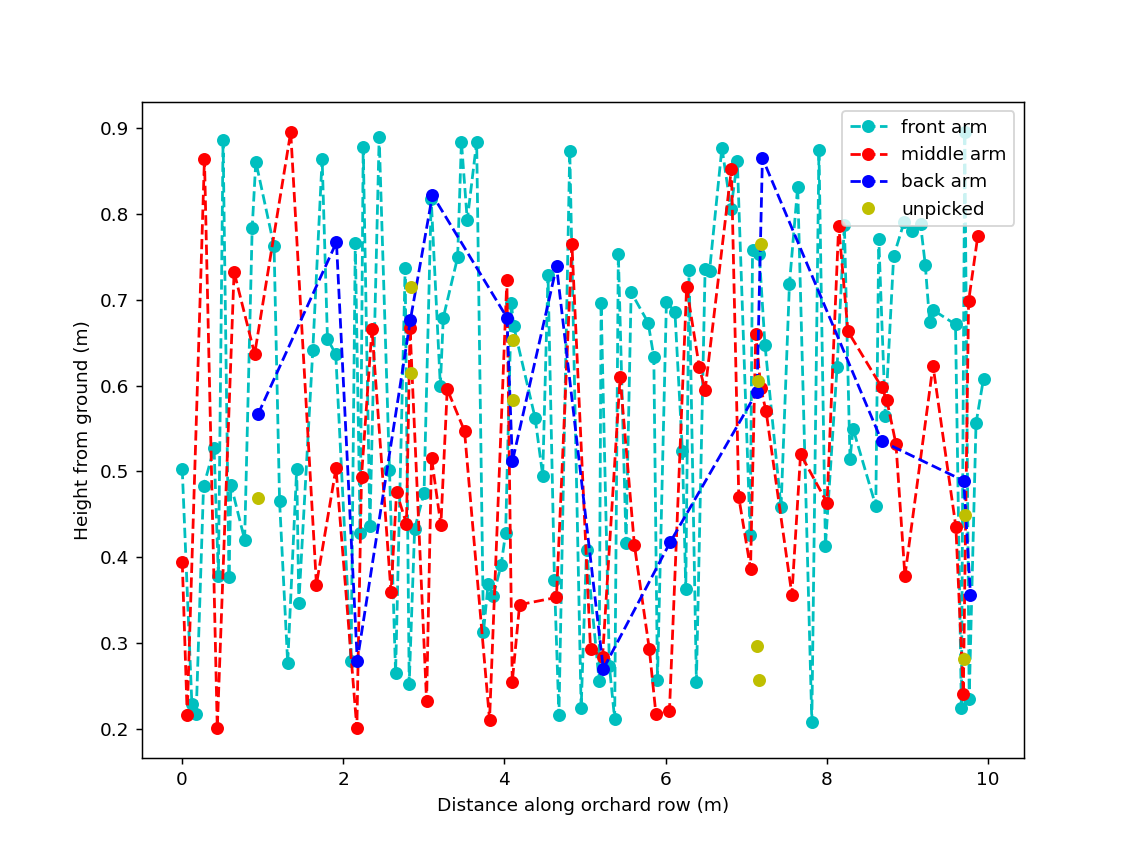

In [11]:
fig, ax = plt.subplots()

plt.plot(sortedFruit[1][fruit_picked_by[0]], 
         sortedFruit[0][fruit_picked_by[0]], 'o--c', label='front arm')

plt.plot(sortedFruit[1][fruit_picked_by[1]], 
         sortedFruit[0][fruit_picked_by[1]], 'o--r',  label='middle arm')

plt.plot(sortedFruit[1][fruit_picked_by[2]], 
         sortedFruit[0][fruit_picked_by[2]], 'o--b',  label='back arm')

plt.plot(sortedFruit[1][fruit_picked_by[3]], 
         sortedFruit[0][fruit_picked_by[3]], 'oy',  label='unpicked')

plt.xlabel('Distance along orchard row (m)')
plt.ylabel('Height from ground (m)')

legend = ax.legend(loc='upper right')
                   
plt.show()

<IPython.core.display.Javascript object>


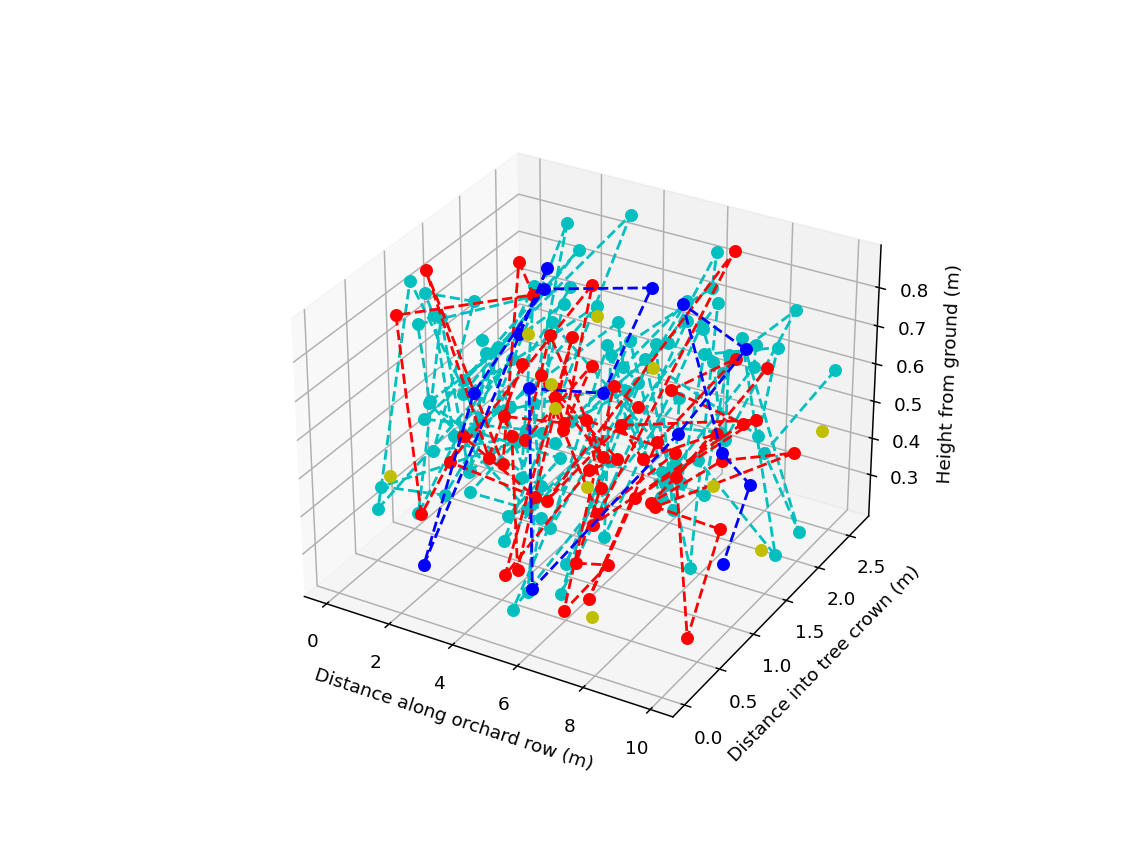

In [12]:
fig = plt.figure()
ax = plt.axes(projection ='3d')

plt.plot(sortedFruit[1][fruit_picked_by[0]], sortedFruit[2][fruit_picked_by[0]], sortedFruit[0][fruit_picked_by[0]], 'o--c')
plt.plot(sortedFruit[1][fruit_picked_by[1]], sortedFruit[2][fruit_picked_by[1]], sortedFruit[0][fruit_picked_by[1]], 'o--r')
plt.plot(sortedFruit[1][fruit_picked_by[2]], sortedFruit[2][fruit_picked_by[2]], sortedFruit[0][fruit_picked_by[2]], 'o--b')
plt.plot(sortedFruit[1][fruit_picked_by[3]], sortedFruit[2][fruit_picked_by[3]], sortedFruit[0][fruit_picked_by[3]], 'oy')


ax.set_xlabel('Distance along orchard row (m)')
ax.set_ylabel('Distance into tree crown (m)')
ax.set_zlabel('Height from ground (m)')

plt.show()

<IPython.core.display.Javascript object>


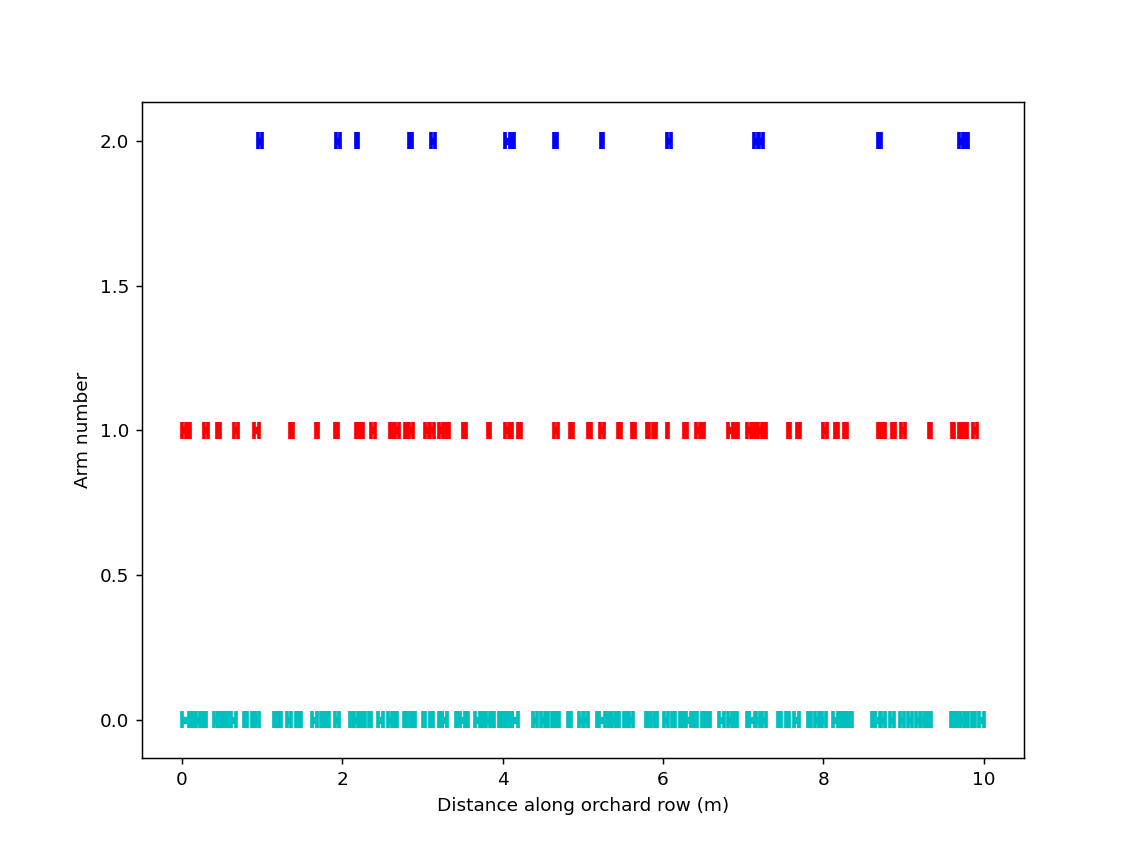

In [15]:
'''Plot the intervals'''
# based on https://stackoverflow.com/questions/7684475/plotting-labeled-intervals-in-matplotlib-gnuplot

# plot is based on distance, not time...
fig, ax = plt.subplots()

for e in IG.edges():
    if e[1].k == 0:
        intervalGraph(e[1].k, e[2], e[3], color='c')
    elif e[1].k == 1:
        intervalGraph(e[1].k, e[2], e[3], color='r')
    elif e[1].k == 2:
        intervalGraph(e[1].k, e[2], e[3], color='b')

plt.xlabel('Distance along orchard row (m)')
plt.ylabel('Arm number')
        
plt.show()



In [8]:
'''What if we just use time intervals...'''

edge_list = list()
k_edges = list()

# calculate the time intervals describing when the arm would be busy picking each fruit (n_arm * numFruit)
for index, y_i in enumerate(sortedFruit[1]):
    # calculate y_i / v which is constant for this fruit
    
    # handling time will not be constant here
    Tw     = calcTd(traj_calc, sortedFruit[0, index], sortedFruit[2, index])
    
    # values of fruit location at the start and end, as well as the handling time
    t_start_0 = y_i / v - Tw # adding the calculated handling time 
    t_end_0   = y_i / v      # the end time will be when the back frame is reached by the fruit 
    
    k_edges.append(index)
    
    for k in range(n_arm):
        # add the offset based on the arm number (assuming back arm is k=0 to front arm k=n_arm)
#         offset = (cell_l*(k+1)) / v  # (k+1) to indicate it's the front frame location we're looking for
        offset = (cell_l*k) / v  # looking at the back part of the frame 
        
        ## Saying here that the fruit can only be picked if arm is not busy when the front of the frame reaches t
        #  the fruit
        
        t_start_k = t_start_0 - offset
        t_end_k   = t_end_0 - offset
        
        if t_start_k > 0 and t_end_k > 0:
            # the interval has to be positive or it cannot be used (impossible to pick that fruit)
            k_edges.append([k, t_start_k, t_end_k])
            
    
    if len(k_edges) > 1:
#         print(k_edges)
        edge_list.append(k_edges.copy()) # if not a copy, values in edge_list also get deleted in next line
    
    # delete values in k_edges
    del k_edges[:]
    
print(edge_list)

[[2, [0, 2.753606665513617, 6.679069586827957]], [3, [0, 8.890002489782287, 12.480147626250936]], [4, [0, 13.257002845953977, 17.802418167642497]], [5, [0, 23.540718986237017, 26.944292385864376]], [6, [0, 23.64905735458389, 28.085998402378575]], [7, [0, 35.28430571970428, 40.00844479907584], [1, 5.284305719704278, 10.00844479907584]], [8, [0, 40.05211753158301, 43.98952086020258], [1, 10.052117531583008, 13.989520860202582]], [9, [0, 41.41045705865932, 45.37611805700104], [1, 11.410457058659318, 15.376118057001037]], [10, [0, 47.066474441288115, 51.186010045683126], [1, 17.066474441288115, 21.186010045683126]], [11, [0, 56.29766883852635, 58.491705953014446], [1, 26.29766883852635, 28.491705953014446]], [12, [0, 56.12805442896551, 60.87745297970471], [1, 26.128054428965513, 30.877452979704707]], [13, [0, 59.336713668462934, 64.82209209449796], [1, 29.336713668462934, 34.82209209449796]], [14, [0, 74.46535266037452, 77.93435332740006], [1, 44.46535266037452, 47.93435332740006], [2, 14.

In [9]:
'''now have to figure out which arm picks what based on time intervals'''
## ASSUMES: arm ready to pick instantly after finishing picking last fruit (no movement time needed)


# (b) process nodes in order of increasing y-coord
# Td = np.zeros(n_arm)
t  = np.zeros([n_arm, numFruit+1]) # t of arm k when *finished picking* (Tm+Td) fruit i

# update this for when there are more than three arms
last_i = np.array([node_array[0], node_array[1], node_array[2]]) # saves the fruit id of the fruit last picked by the arm k 
curr_j = np.array([node_array[0].j, node_array[1].j, node_array[2].j]) # saves the number of fruit being picked by 
# the kth arm

for e in edge_list:
    i   = e[0] ## causes below k+1 because e[0] is i (fruit num)
    
    for k in range(len(e)-1):
        # the arm number (changes based on how many intervals had negative values) 
        # => not all arms could pick fruit
#         print('arm number', k)
#         print('start:', e[k+1][1], 'end:', e[k+1][2]) 
        
        # take the previously chosen i for arm k and add in the move time to new i
        prev = sortedFruit[1, last_i[k].i] 
        # calculate how far the vehicle moves between the interval end of y_(i-1) and interval start of y_i
        veh_move = (e[k+1][1] - last_i[k].t)*v  
        
        # move to new location arrived when moving to get the next fruit
        # ends in line with previous fruit plus the distance the vehicle moves between the end time of last fruit
        # and the beginning time of this one
        start_y = prev + veh_move      
        start_z = 0.                          # ends at the bottom to drop off the fruit
        
        print('y_(i-1):', prev, 'y_i:', sortedFruit[1,i])
        print('removed vehicle move y(i-1):', start_y, 'veh move:', veh_move)
        
        # new fruit's location
        fruit_y = sortedFruit[1,i]
        fruit_z = sortedFruit[2,i]
        
        # calculate how long it would take to reach new fruit
        Tm = calcTm(traj_calc, start_y, start_z, fruit_y, fruit_z)
        
        start_time = e[k+1][1] - Tm # add movement into work before handling to get the true total time interval
        
        # careful with reference, the return should actually be ((u,v), begin, end)
        # https://dynetworkx.readthedocs.io/en/latest/reference/classes/generated/dynetworkx.IntervalGraph.edges.html#dynetworkx.IntervalGraph.edges
#         n_interval = IG.edges(begin=e[k+1][1], end=e[k+1][2]) # check if there are edges that lie between the new edges?
#         print('number of intervals that fall within the current calculated edges',len(n_interval))

#         is_busy    = IG.edges(v=last_i[k], begin=e[k+1][1], end=e[k+1][2])
#         print('is arm', k, 'already busy for this interval?', len(is_busy))
        
        n_interval = IG.edges(begin=start_time, end=e[k+1][2]) # check if there are edges that lie between the new edges?
        print('number of intervals that fall within the current calculated edges',len(n_interval))

        is_busy    = IG.edges(v=last_i[k], begin=start_time, end=e[k+1][2])
        print('is arm', k, 'already busy for this interval?', len(is_busy))

        if len(n_interval) < n_arm and len(is_busy) < 1: 
            # add an edge between the last node and this node with interval edge U
            print('      add edge')
#             IG.add_edge(last_i[k], node_array[i+n_arm], e[k+1][1], e[k+1][2])
            IG.add_edge(last_i[k], node_array[i+n_arm], start_time, e[k+1][2])

            # update the node
            node_array[i+n_arm].j = curr_j[k] + 1
            node_array[i+n_arm].k = k
            node_array[i+n_arm].t = e[k+1][2]   

            # update all the saved prev node data
            last_i[k] = node_array[i+n_arm]
            curr_j[k] = node_array[i+n_arm].j # maybe don't need to save this array, just use last_i

            # skip this fruit for the rest of the arms
            print()
            break

y_(i-1): 0.005292470942258598 y_i: 0.06679069586827957
removed vehicle move y(i-1): 0.03282853759739477 veh move: 0.027536066655136172
number of intervals that fall within the current calculated edges 0
is arm 0 already busy for this interval? 0
      add edge

y_(i-1): 0.06679069586827957 y_i: 0.12480147626250937
removed vehicle move y(i-1): 0.08890002489782287 veh move: 0.022109329029543295
number of intervals that fall within the current calculated edges 1
is arm 0 already busy for this interval? 1
y_(i-1): 0.06679069586827957 y_i: 0.17802418167642498
removed vehicle move y(i-1): 0.13257002845953977 veh move: 0.0657793325912602
number of intervals that fall within the current calculated edges 0
is arm 0 already busy for this interval? 0
      add edge

y_(i-1): 0.17802418167642498 y_i: 0.26944292385864377
removed vehicle move y(i-1): 0.2354071898623702 veh move: 0.05738300818594521
number of intervals that fall within the current calculated edges 0
is arm 0 already busy for this int

removed vehicle move y(i-1): 6.173200798376682 veh move: 0.05836692489553002
number of intervals that fall within the current calculated edges 0
is arm 0 already busy for this interval? 0
      add edge

y_(i-1): 6.20795145403725 y_i: 6.249766869796205
removed vehicle move y(i-1): 6.22706146330561 veh move: 0.019110009268359818
number of intervals that fall within the current calculated edges 0
is arm 0 already busy for this interval? 0
      add edge

y_(i-1): 6.249766869796205 y_i: 6.260160158947575
removed vehicle move y(i-1): 6.22043659803657 veh move: -0.029330271759635027
number of intervals that fall within the current calculated edges 2
is arm 0 already busy for this interval? 1
y_(i-1): 6.0562842548138 y_i: 6.260160158947575
removed vehicle move y(i-1): 6.22043659803657 veh move: 0.16415234322277003
number of intervals that fall within the current calculated edges 1
is arm 1 already busy for this interval? 0
      add edge

y_(i-1): 6.249766869796205 y_i: 6.290296606857684
rem

In [10]:
print('Total number of fruit:', numFruit)
print('Total harvested fruit:', np.sum(curr_j), 'or', np.sum(curr_j)/numFruit, '%')
print('Number of fruit picked by arm 0:', curr_j[0], 'arm 1:', curr_j[1], 'arm 2:', curr_j[2])

Total number of fruit: 189
Total harvested fruit: 165 or 0.873015873015873 %
Number of fruit picked by arm 0: 98 arm 1: 52 arm 2: 15


In [11]:
IG.edges()

fruit_picked_by = list()
for k in range(n_arm+1):
    fruit_picked_by.append([])

for i in range(n_arm, numFruit+n_arm):
    fruit_picked_by[node_array[i].k].append(node_array[i].i)

print(fruit_picked_by)

[[2, 4, 5, 7, 10, 11, 14, 15, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 33, 35, 37, 40, 42, 43, 45, 47, 51, 54, 55, 57, 60, 63, 64, 66, 68, 69, 71, 72, 73, 74, 77, 83, 84, 85, 86, 87, 90, 91, 93, 95, 96, 99, 100, 102, 104, 106, 107, 109, 111, 112, 113, 115, 116, 117, 120, 122, 125, 126, 128, 130, 133, 137, 142, 144, 145, 146, 148, 149, 150, 152, 153, 155, 156, 158, 159, 161, 164, 166, 167, 169, 170, 172, 174, 175, 177, 183, 186, 188], [8, 12, 16, 23, 25, 31, 34, 36, 38, 41, 44, 48, 56, 59, 61, 65, 67, 70, 75, 78, 88, 92, 94, 97, 101, 103, 105, 108, 110, 114, 118, 121, 123, 127, 129, 131, 135, 143, 147, 151, 154, 157, 160, 163, 165, 168, 171, 173, 176, 178, 184, 187], [17, 32, 46, 49, 58, 62, 76, 80, 89, 119, 132, 136, 162, 179, 185], [0, 1, 3, 6, 9, 13, 18, 39, 50, 52, 53, 79, 81, 82, 98, 124, 134, 138, 139, 140, 141, 180, 181, 182]]


<IPython.core.display.Javascript object>


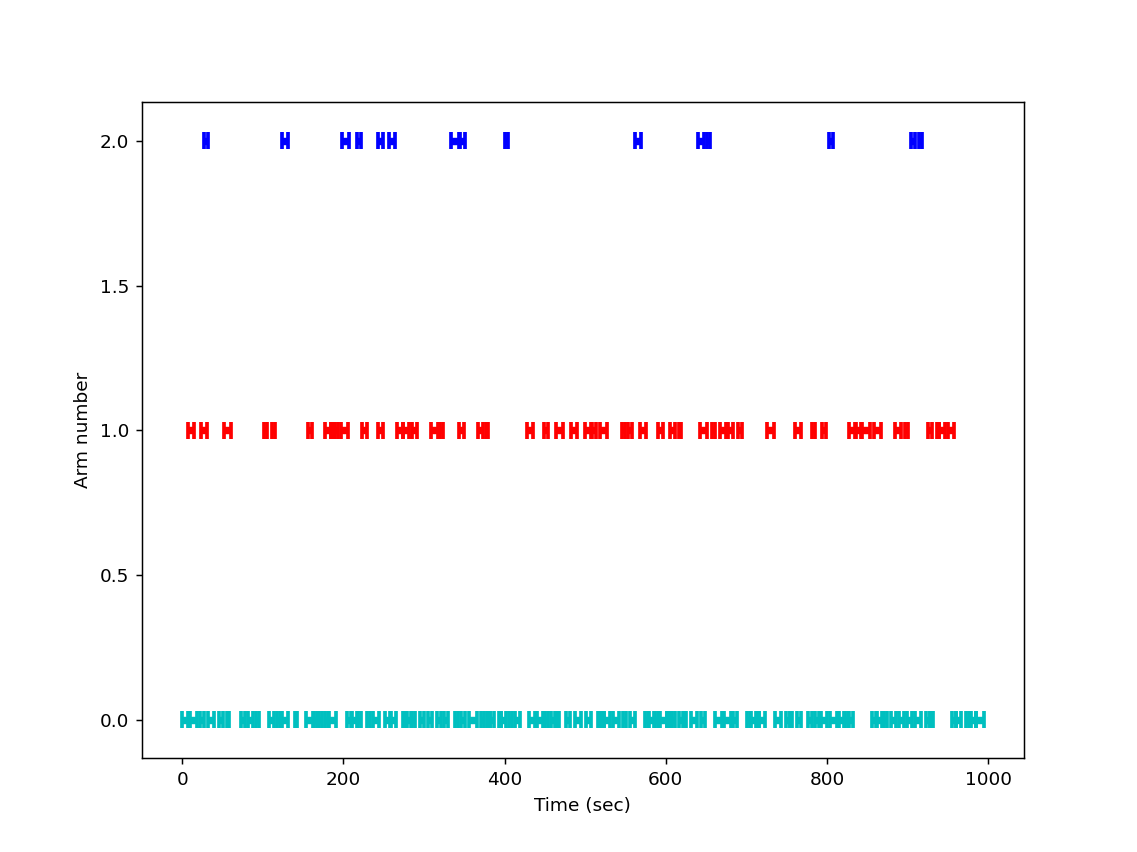

In [12]:
'''Plot the intervals -- Testing time not distance intervals'''
# based on https://stackoverflow.com/questions/7684475/plotting-labeled-intervals-in-matplotlib-gnuplot

# plot is based on time...
fig, ax = plt.subplots()

for e in IG.edges():
    if e[1].k == 0:
        intervalGraph(e[1].k, e[2], e[3], color='c')
    elif e[1].k == 1:
        intervalGraph(e[1].k, e[2], e[3], color='r')
    elif e[1].k == 2:
        intervalGraph(e[1].k, e[2], e[3], color='b')

plt.xlabel('Time (sec)')
plt.ylabel('Arm number')
        
plt.show()

<IPython.core.display.Javascript object>


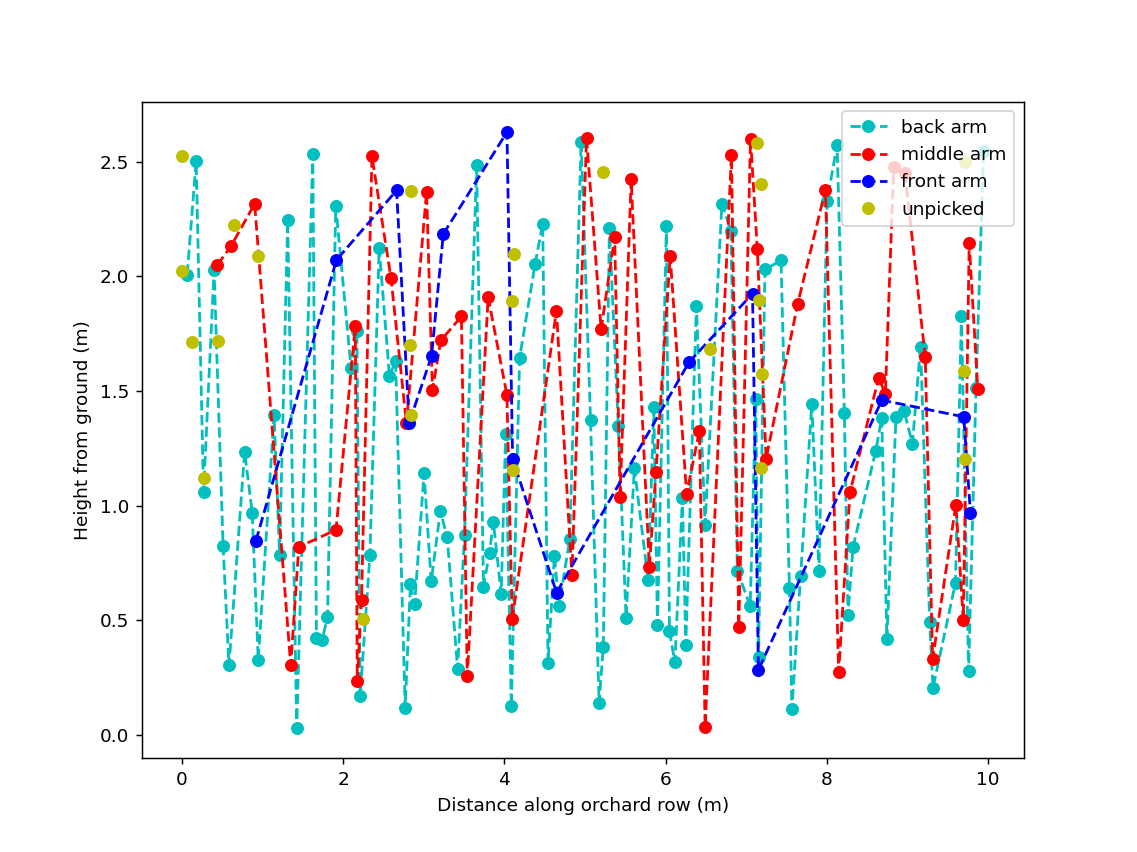

In [13]:
fig, ax = plt.subplots()

plt.plot(sortedFruit[1][fruit_picked_by[0]], 
         sortedFruit[2][fruit_picked_by[0]], 'o--c', label='back arm')

plt.plot(sortedFruit[1][fruit_picked_by[1]], 
         sortedFruit[2][fruit_picked_by[1]], 'o--r',  label='middle arm')

plt.plot(sortedFruit[1][fruit_picked_by[2]], 
         sortedFruit[2][fruit_picked_by[2]], 'o--b',  label='front arm')

plt.plot(sortedFruit[1][fruit_picked_by[3]], 
         sortedFruit[2][fruit_picked_by[3]], 'oy',  label='unpicked')

plt.xlabel('Distance along orchard row (m)')
plt.ylabel('Height from ground (m)')

legend = ax.legend(loc='upper right')
                   
plt.show()

<IPython.core.display.Javascript object>


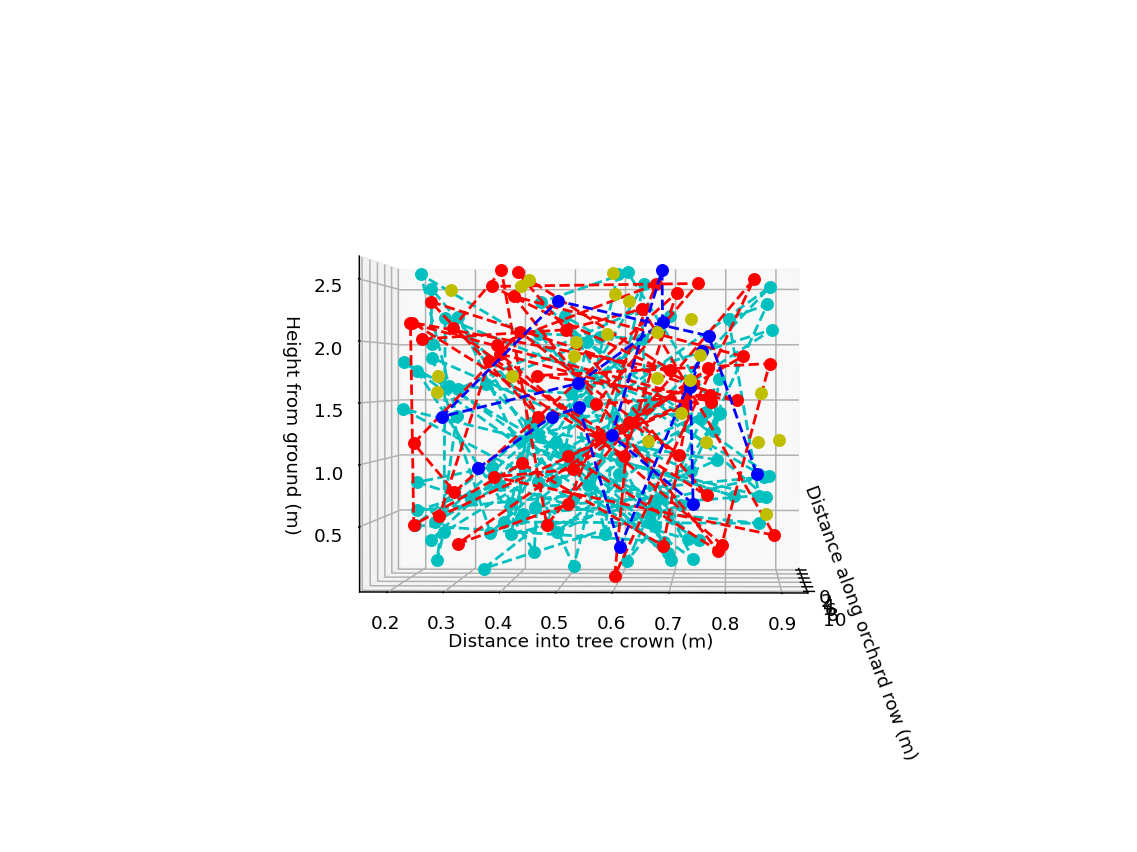

In [14]:
fig = plt.figure()
ax = plt.axes(projection ='3d')

plt.plot(sortedFruit[1][fruit_picked_by[0]], sortedFruit[0][fruit_picked_by[0]], sortedFruit[2][fruit_picked_by[0]], 'o--c')
plt.plot(sortedFruit[1][fruit_picked_by[1]], sortedFruit[0][fruit_picked_by[1]], sortedFruit[2][fruit_picked_by[1]], 'o--r')
plt.plot(sortedFruit[1][fruit_picked_by[2]], sortedFruit[0][fruit_picked_by[2]], sortedFruit[2][fruit_picked_by[2]], 'o--b')
plt.plot(sortedFruit[1][fruit_picked_by[3]], sortedFruit[0][fruit_picked_by[3]], sortedFruit[2][fruit_picked_by[3]], 'oy')


ax.set_xlabel('Distance along orchard row (m)')
ax.set_ylabel('Distance into tree crown (m)')
ax.set_zlabel('Height from ground (m)')

plt.show()